In [0]:
%fs ls /FileStore/tables/first_project

path,name,size,modificationTime
dbfs:/FileStore/tables/first_project/members.csv,members.csv,48,1706310259000
dbfs:/FileStore/tables/first_project/menu.csv,menu.csv,63,1706310259000
dbfs:/FileStore/tables/first_project/sales.csv,sales.csv,259,1706310259000


Import all necessary libraries

In [0]:
# import sql types to define our schemas
from pyspark.sql.types import *

# import all SQL functions as F to clean and transform data
import pyspark.sql.functions as F

# to do windows functions
from pyspark.sql.window import Window

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
#dictionary for the all file locations
files = {
    'menu': '/FileStore/tables/first_project/menu.csv',
    'members': '/FileStore/tables/first_project/members.csv',
    'sales': '/FileStore/tables/first_project/sales.csv'
}

In [0]:
# Take a look at the data
df_menu = spark.read.csv(files['menu'], header=True, inferSchema=True)
display(df_menu)

# header=True indicates that the first row in the data contains the header, which will be used as column names.
# inferSchema=True instructs PySpark to automatically infer the data types of each column.

product_id,product_name,price
1,sushi,10
2,curry,15
3,ramen,12


In [0]:
df_sales = spark.read.csv(files['sales'], header=True, inferSchema=True)
display(df_sales)

customer_id,order_date,product_id
A,2021-01-01,1
A,2021-01-01,2
A,2021-01-07,2
A,2021-01-10,3
A,2021-01-11,3
A,2021-01-11,3
B,2021-01-01,2
B,2021-01-02,2
B,2021-01-04,1
B,2021-01-11,1


In [0]:
df_members = spark.read.csv(files['members'], header=True, inferSchema=True)
display(df_members)

customer_id,join_date
A,2021-01-07
B,2021-01-09


If you don't specify a schema, PySpark will attempt to infer it dynamically based on the data in the source, which is convenient but may result in longer job startup times.
- We use 'StructType' to specify the overall structure of our DataFrame by defining list of 'StructField' objects
- 'StructField' is used to define a single field (column) within a 'StructType'
- Each 'StructField' contains three main parameter, column name, data type,

If we concerns about performane and data quality, better we specify our table schema

In [0]:
# Define the proper schema
menu_schema = StructType([
    StructField('product_id', IntegerType(), False),
    StructField('product_name', StringType(), False),
    StructField('price', IntegerType(), False)
])

sales_schema = StructType ([
    StructField('customer_id', StringType(), False),
    StructField('order_date', DateType(), False),
    StructField('product_id', IntegerType(), False)
])

members_schema = StructType ([
    StructField('customer_id', StringType(), False),
    StructField('join_date', DateType(), False)
])

In [0]:
# Create the file pyspark DataFrame for menu table
menu_df = (
    spark
    .read.format('csv')
    .options(header=True)
    .schema(menu_schema)
    .load(files['menu'])
    )
display(menu_df)

product_id,product_name,price
1,sushi,10
2,curry,15
3,ramen,12


In [0]:
# Create the file pyspark DataFrame for sales table
sales_df = (
    spark
    .read.format('csv')
    .options(header=True)
    .schema(sales_schema)
    .load(files['sales'])
    )
display(sales_df)

customer_id,order_date,product_id
A,2021-01-01,1
A,2021-01-01,2
A,2021-01-07,2
A,2021-01-10,3
A,2021-01-11,3
A,2021-01-11,3
B,2021-01-01,2
B,2021-01-02,2
B,2021-01-04,1
B,2021-01-11,1


In [0]:
# Create the file pyspark DataFrame for members table
members_df = (
    spark
    .read.format('csv')
    .options(header=True)
    .schema(members_schema)
    .load(files['members'])
    )
display(members_df)

customer_id,join_date
A,2021-01-07
B,2021-01-09


### 1. How much each customer spend in the restaurant?

To answer this question, we need join sales df and menu df first and then we calculate total sales by summing the values based on the price and then grouped by customer_id

In [0]:
Q1= (
    sales_df
    .join(
        menu_df,
        sales_df.product_id == menu_df.product_id,
        "inner")
    .groupBy('customer_id')
    .agg(
        F.sum('price').alias('Total Spend'))
    .orderBy(F.col('Total Spend').desc())
)
display(Q1)

customer_id,Total Spend
A,76
B,74
C,36


We can see from table generated above, each customer with their total spend. We can graph too using toPandas

Out[12]: <function matplotlib.pyplot.show(close=None, block=None)>

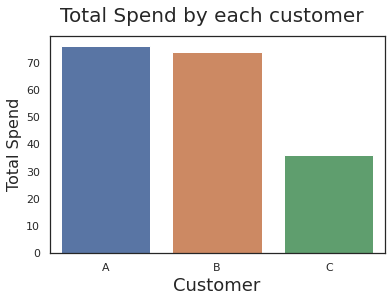

In [0]:
Q1_pandas = Q1.toPandas()
sns.set('notebook')
sns.set_style('white')
fig, ax = plt.subplots()

sns.barplot(
    data=Q1_pandas,
    x='customer_id',
    y='Total Spend',
    ax=ax
)

fig.suptitle('Total Spend by each customer', fontsize=20)
plt.xlabel('Customer', fontsize=18),
plt.ylabel('Total Spend', fontsize=16)

plt.show

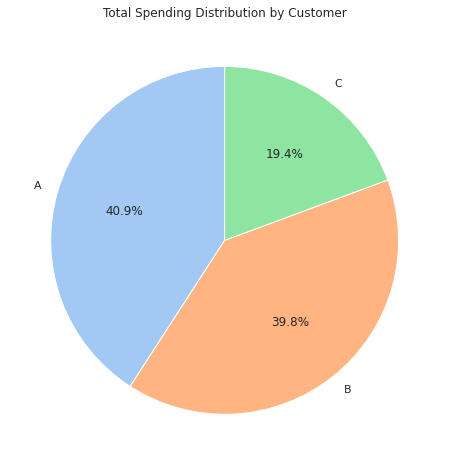

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

customer_ids = Q1_pandas['customer_id']
total_spend = Q1_pandas['Total Spend']

# Set the color palette
colors = sns.color_palette('pastel')[0:len(customer_ids)]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.title('Total Spending Distribution by Customer')
plt.pie(total_spend, labels=customer_ids, autopct='%1.1f%%', colors=colors, startangle=90)
plt.show()


### Q2: How many days has each client visited the restaurant?

To answer this question, we can focus on sales table.
We can group customer id and count distinct order date 

In [0]:
Q2 = (
    sales_df
    .groupBy('customer_id')
    .agg(
        F.countDistinct('order_date').alias('Days')
    )
    .orderBy(F.col('Days').desc())
)
display(Q2)

customer_id,Days
B,6
A,4
C,2


Databricks visualization. Run in Databricks to view.

Out[15]: <function matplotlib.pyplot.show(close=None, block=None)>

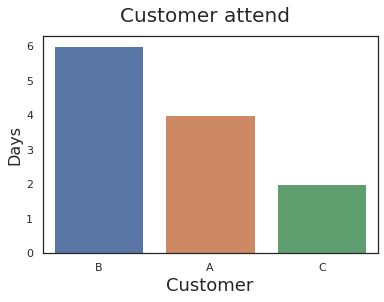

In [0]:
Q2_pandas = Q2.toPandas()
sns.set('notebook')
sns.set_style('white')
fig, ax = plt.subplots()

sns.barplot(
    data=Q2_pandas,
    x='customer_id',
    y='Days',
    ax=ax
)

fig.suptitle('Customer attend', fontsize=20)
plt.xlabel('Customer', fontsize=18),
plt.ylabel('Days', fontsize=16)

plt.show

### Which was the first item each client bought?

To answer this question, we can join table sales and menu, use create new column to write new index based on customer_id and order by their order date. After that, we can return what we need using filter only row number == 1, and select only desire column


In [0]:
Q3 = (
    sales_df
    .join(
        menu_df,
        sales_df.product_id == menu_df.product_id,
        "inner"
    )

    # get the row_number using partition by customer, ordering by order_Date
    .withColumn(
        'row_number', F.row_number().over(
            Window
            .partitionBy('customer_id')
            .orderBy('order_date')
        )
    )
    # only return the data we need
    .filter('row_number==1')
    .select('customer_id', 'order_date', 'product_name')

    #rename the column name so it will more understandable
    .withColumnRenamed('product_name', 'first item')
    .withColumnRenamed('order_date', 'date of first order')
)
display(Q3)

customer_id,date of first order,first item
A,2021-01-01,sushi
B,2021-01-01,curry
C,2021-01-01,ramen


### Which was the most popular plate in the menu? How many times did the customers buy it?

Looks like we need to look at the sales table. But don't forget to join sales table with the menu table first to get information about the product name. Subsequently, we can group the table by product_name, count occurrences of each product_name, and then arrange the results in descending order based on total sales. Finally, we can limit the output to just one result.

In [0]:
Q4 = (
    sales_df
    .join(
        menu_df,
        sales_df.product_id == menu_df.product_id,
        'inner'
    )
    .groupBy('product_name')
    .agg(
        F.count('product_name').alias('Total Sales')
    )
    .orderBy(F.col('Total Sales').desc())
    .limit(1)
)

display(Q4)

product_name,Total Sales
ramen,8


### Which was the most preffered plate by each customer?

Looks like we need to make a new column called rank using partition based on customer_id and order it by total sales. Don't forget to filter only the most preferred plate

In [0]:
Q5 = (
    sales_df
    .join(
        menu_df,
        sales_df.product_id == menu_df.product_id,
        'inner'
    )
    .groupBy('customer_id','product_name')
    .agg(
        F.count('product_name').alias('Total Sales')
    )

    #get rank number using partition by customer id and order by total sales 
    .withColumn('plate_rank', F.rank().over(
        Window
        .partitionBy('customer_id')
        .orderBy(F.col('Total Sales').desc())
    ))
    #.orderBy(F.col('plate_rank').asc())
    .filter('plate_rank==1')
)

display(Q5)

customer_id,product_name,Total Sales,plate_rank
A,ramen,3,1
B,sushi,2,1
B,ramen,2,1
B,curry,2,1
C,ramen,3,1


### What was the first item after the client became member?

we can take a look at members table first, we have customer_id and join_date. 
And then, we look at sales table

we can return only customer_id with order_date has the same date with join_date

In [0]:
Q6 = (
    members_df
    .join(
        sales_df,
        (members_df.customer_id == sales_df.customer_id)
            & (members_df.join_date <= sales_df.order_date)
    )
    .withColumn('order_rank', F.rank().over(
        Window
        .partitionBy(members_df.customer_id)
        .orderBy(F.col('order_date'))
    ))
    .filter('order_rank==1')
    
)

Q6.show()

+-----------+----------+-----------+----------+----------+----------+
|customer_id| join_date|customer_id|order_date|product_id|order_rank|
+-----------+----------+-----------+----------+----------+----------+
|          A|2021-01-07|          A|2021-01-07|         2|         1|
|          B|2021-01-09|          B|2021-01-11|         1|         1|
+-----------+----------+-----------+----------+----------+----------+



Nice job, now you have table with information customer_id and product_id who is the first order after join member. the next question is how to join menu table so our table would be complete

In [0]:
Q6 = (
    members_df
    .join(
        sales_df,
        (members_df.customer_id == sales_df.customer_id)
            & (members_df.join_date <= sales_df.order_date)
    ).join (
        menu_df,
        "product_id"
    )
    .withColumn('order_rank', F.rank().over(
        Window
        .partitionBy(members_df.customer_id)
        .orderBy(F.col('order_date'))
    ))
    .filter('order_rank==1')
    .select([sales_df.customer_id, "join_date", "order_date", "product_name"] )
    
)

Q6.show()

+-----------+----------+----------+------------+
|customer_id| join_date|order_date|product_name|
+-----------+----------+----------+------------+
|          A|2021-01-07|2021-01-07|       curry|
|          B|2021-01-09|2021-01-11|       sushi|
+-----------+----------+----------+------------+



### What was the item before the client became member?

In [0]:
Q7 = (
    members_df
    .join(
        sales_df,
        (members_df.customer_id == sales_df.customer_id)
            & (members_df.join_date > sales_df.order_date)
    ).join (
        menu_df,
        "product_id"
    )
    .withColumn('order_rank', F.rank().over(
        Window
        .partitionBy(members_df.customer_id)
        .orderBy(F.col('order_date').desc())
    ))
    .filter('order_rank==1')
    .select([sales_df.customer_id, "join_date", "order_date", "product_name"] )
    
)

Q7.show()

+-----------+----------+----------+------------+
|customer_id| join_date|order_date|product_name|
+-----------+----------+----------+------------+
|          A|2021-01-07|2021-01-01|       sushi|
|          A|2021-01-07|2021-01-01|       curry|
|          B|2021-01-09|2021-01-04|       sushi|
+-----------+----------+----------+------------+



### How much money and articles did a customer buy before becoming a member?

In [0]:
Q8 = (
    members_df
    .join(
        sales_df,
        (members_df.customer_id == sales_df.customer_id)
            & (members_df.join_date > sales_df.order_date)
    ).join (
        menu_df,
        "product_id"
    )
    .withColumn('order_rank', F.rank().over(
        Window
        .partitionBy(members_df.customer_id)
        .orderBy(F.col('order_date').desc())
    ))
    .groupBy (
        members_df.customer_id
    )
    .agg (
        F.sum('price')
    )
    
)

display(Q8)

customer_id,sum(price)
B,40
A,25


### If each $1 is worth of 10 points and when is sushi you get double points? How much points each customer has?

In [0]:
Q9 = (
    sales_df
    .join(
        menu_df,
        "product_id"
    )
    .withColumn(
        "points",
        F.when(menu_df.product_name == 'sushi', (menu_df.price * 10 * 2)).otherwise(menu_df.price*10)
    )
    .groupBy(
        "customer_id"
    )
    .agg(
        F.sum("points").alias("Total points")
    )
    .orderBy(
        F.col("Total points").desc())
)

display(Q9)

customer_id,Total points
B,940
A,860
C,360


Databricks visualization. Run in Databricks to view.

### On the first week after a client is a member (including the join date), it earns double points, not only on Sushi. How many points will customers A and B have at the end of January?

In [0]:
Q10 = (
    sales_df
    .join(
        menu_df,
        "product_id"
    )
    .join(
        members_df,
        "customer_id"
    )
    .withColumn(
        "points",
        F.when( (sales_df.order_date >= members_df.join_date) & (sales_df.order_date <= members_df.join_date + 7), menu_df.price*10*2)
        .when(((sales_df.order_date < members_df.join_date) | (sales_df.order_date > members_df.join_date +7)) & (menu_df.product_name == 'sushi'), menu_df.price*10*2 )
        .otherwise(menu_df.price*10)
    )
    .filter(sales_df.order_date < '2021-02-01')
    .groupBy(
          "customer_id"
      )
      .agg(
          F.sum("points").alias("Total points")
      )
      .orderBy(
          F.col("Total points").desc())
)

Q10.show()

+-----------+------------+
|customer_id|Total points|
+-----------+------------+
|          A|        1370|
|          B|         940|
+-----------+------------+



In [0]:
display(Q10)

customer_id,Total points
A,1370
B,940


Databricks visualization. Run in Databricks to view.